In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
import csv
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor


def agent2(a_shape, s_shape):
    actor = branch_actor(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent2(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        original_noise=True,
        action_clipper=[-10., 10.],
        tau_clipper=[0.001, 1.],
        params_logging=False,
        gradient_logging=False,
        batch_size=128,
    )
    return agent

In [4]:
# agent compilation
l = 1.
step = 50000  # num of interval
episode_step = step
a = agent2((2,), (2,))
actor_optimizer, critic_optimizer = Adam(lr=100., clipnorm=1.), Adam(lr=0.001, clipnorm=1.) # actorの方は何でもいい
optimizer = [actor_optimizer, critic_optimizer]
a.compile(optimizer=optimizer, metrics=["mse"], action_lr=0.0001, tau_lr=0.001)

In [29]:
# agent setup
a.actor.load_weights('../saved_agent/learned_self.h5')
a.training = False

-4.234861595210882e-217
-5.512489489795305e-217
-5.006019252782338e-217
-5.714828028540559e-217
-6.058091807748063e-217
-6.067979366360828e-217
-6.84601670307477e-217
-6.415142704467241e-217
-6.24121906477862e-217
-6.21678325854041e-217


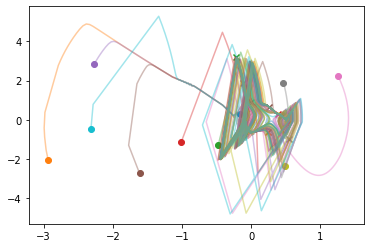

In [30]:
# experiment

l = 1.
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# step wise evaluation

step_limit = 1000
n_episodes = 10
gamma = .99
average_reward = 0


for ep in range(n_episodes):
    state_log = []
    env.reset()
    episode_reward = 0
    for steps in range(step_limit):
        reward = 0
        x = env.state
        a_agent, tau = a.forward(x)
        state_log.append(x)
        action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.005
        dt = tau / action_repetition
        for p in range(action_repetition):
            _,_,r,_ = env.step(np.array([a_agent]), dt, tau)
            reward += r
        reward *= dt
        reward += - 0.01 * a_agent**2 + l * tau # step reward

        episode_reward += pow(gamma, step) * reward
    print(episode_reward)
    average_reward += episode_reward / n_episodes
    state_log = np.array(state_log)
    plt.plot(state_log[:,0], state_log[:,1], alpha=0.4, color=cycle[ep])
    plt.scatter(state_log[0,0], state_log[0,1], marker='o', color=cycle[ep])
    plt.scatter(state_log[-1,0], state_log[-1,1], marker='x', color=cycle[ep])
plt.show()